<a href="https://colab.research.google.com/github/Dare-Badejo-001/Optimization-Problems/blob/main/MAD_Porfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null

solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

In [ ]:
!pip install yfinance --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.6 MB/s eta 0:00:00


In [ ]:
# import the necessary files
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import datetime as datetime
import yfinance as yf

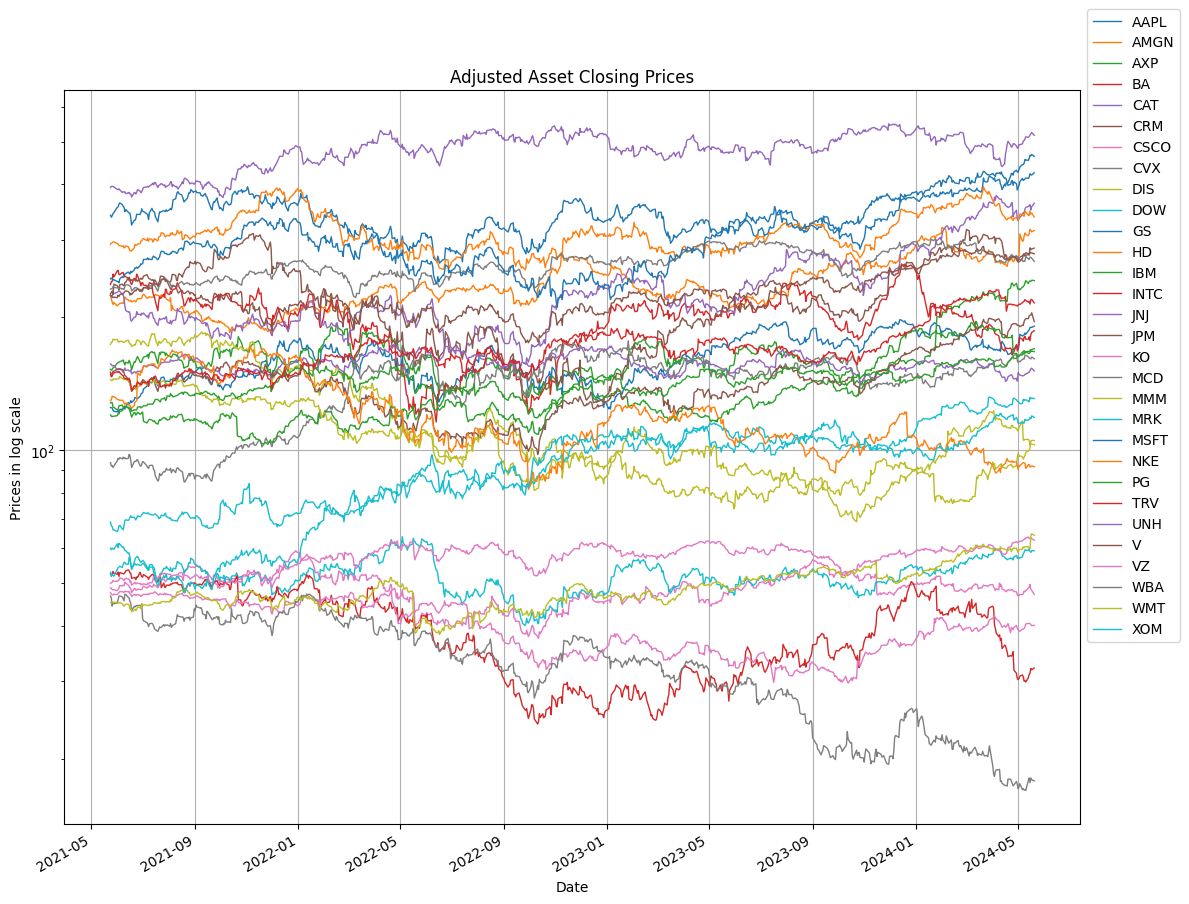

In [ ]:
# dowload the historic stock price dataset

# list of stock symbols
tickers = ["AXP","AAPL","AMGN","BA",
    "CAT", "CRM", "CSCO", "CVX",
    "DIS", "DOW", "GS", "HD",
    "IBM","INTC", "JNJ", "JPM",
    "KO",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "V",
    "VZ",
    "WBA",
    "WMT",
    "XOM",
]

n_years = 3.0
end_date = datetime.datetime.today().date()
start_date = end_date - datetime.timedelta(round(n_years * 365))

assets = yf.download(tickers, start=start_date, end=end_date, progress=False)["Adj Close"]

assets.fillna(method="bfill", inplace=True)
assets.fillna(method="ffill", inplace=True)

fig, ax = plt.subplots(figsize=(12, 9))
assets.plot(ax=ax, logy=True, grid=True, lw=1, title="Adjusted Asset Closing Prices")
ax.legend(bbox_to_anchor=(1.0, 1.12))
ax.set_ylabel("Prices in log scale")
plt.tight_layout()
plt.show()

## Analysis of historical asset prices

### Scaled Asset Prices
Historical prices are adjusted to start at a unit value, aiding plotting and calculations while maintaining returns for analysis.

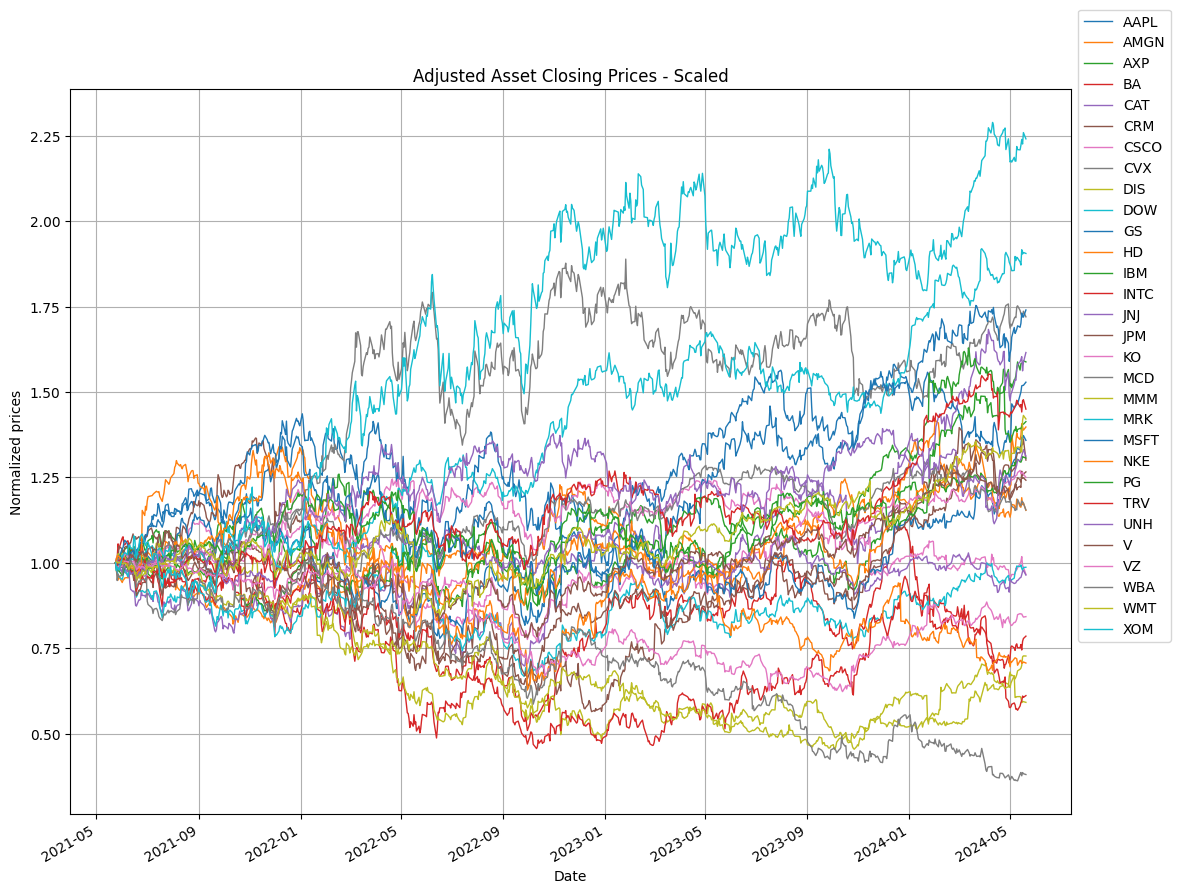

In [ ]:
assets_scaled = assets.div(assets.iloc[0])

fig, ax = plt.subplots(figsize=(12, 9))
assets_scaled.plot(
    ax=ax, grid=True, lw=1, title="Adjusted Asset Closing Prices - Scaled"
)
ax.legend(bbox_to_anchor=(1.0, 1.12))
ax.set_ylabel("Normalized prices")
plt.rcParams["font.size"] = 13
plt.tight_layout()
plt.show()

### Statistics of daily returns

$S_{j, i}$ = Scaled price of asset $j$ on day $t$

The daily return $r_{j, t}$ is

$$r_{j, t} = \frac{S_{j, t} - S_{j, t-1}}{S_{j, t-1}}$$

for  $t = 1, \dots, T$.

The mean return $\bar{r}_j$ for asset $j$ is:

$$\bar{r}_j = \frac{1}{T} \sum_{t=1}^T r_{j, t}$$


Daily returns is computed for all assets and display as a time series and histograms

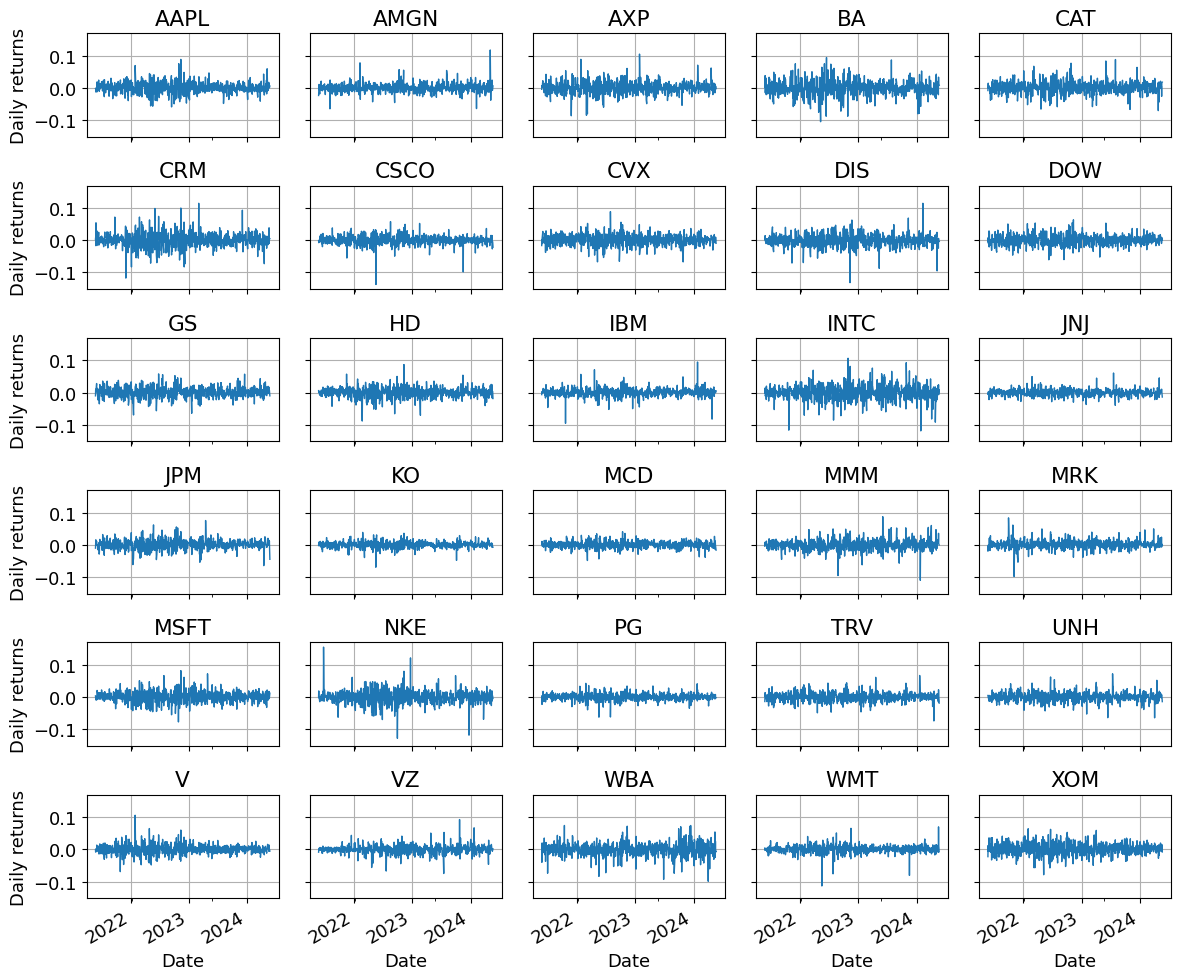

In [ ]:
daily_returns = assets.diff()[1:] / assets.shift(1)[1:]

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)

for a, s in zip(ax.flatten(), sorted(daily_returns.columns)):
    daily_returns[s].plot(ax=a, lw=1, title=s, grid=True)
    a.xaxis.set_major_locator(mdates.YearLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    a.set_ylabel("Daily returns")

plt.tight_layout()
plt.show()

### Mean Absolute Deviation

The mean absolute deviation $\Delta_j$ for asset $j$ is

$$\Delta_j = \frac{1}{T} \sum_{t=1}^T | r_{j,t} - \bar{r}_j |$$

where $T$ is the period under consideration.

We now calculate the mean daily return and the mean absolute deviation in daily returns for all assets and display the distributions of daily returns for all assets.

For each asset, we depict the mean return $\bar{r}$ (in red) and the interval $[\bar{r}-\Delta,\bar{r}+\Delta]$ whose size corresponds to its mean absolute deviation (in green).

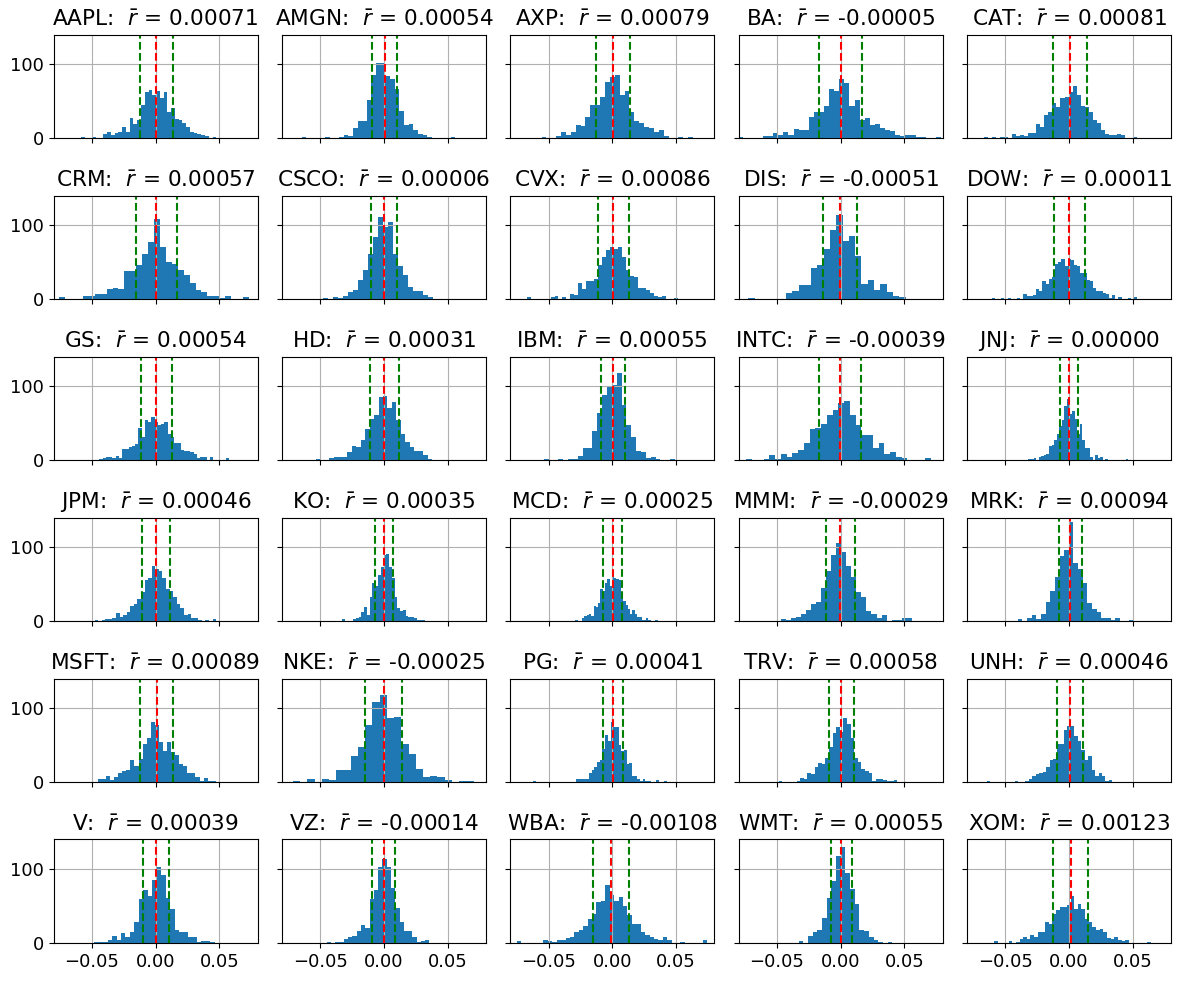

In [ ]:
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

for a, s in zip(ax.flatten(), daily_returns.columns):
    daily_returns[s].hist(ax=a, lw=1, grid=True, bins=50)
    a.set_title(f"{s}:  $\\bar r$ = {mean_return[s]:0.5f}")
    a.set_xlim(-0.08, 0.08)
    a.axvline(mean_return[s], color="r", linestyle="--")
    a.axvline(mean_return[s] + mean_absolute_deviation[s], color="g", linestyle="--")
    a.axvline(mean_return[s] - mean_absolute_deviation[s], color="g", linestyle="--")

plt.tight_layout()
plt.show()

The mean daily return and the mean absolute deviation in daily returns are plotted as bar charts in the following cell. The side by side comparison provides a comparison of return vs. volatility for individual assets.

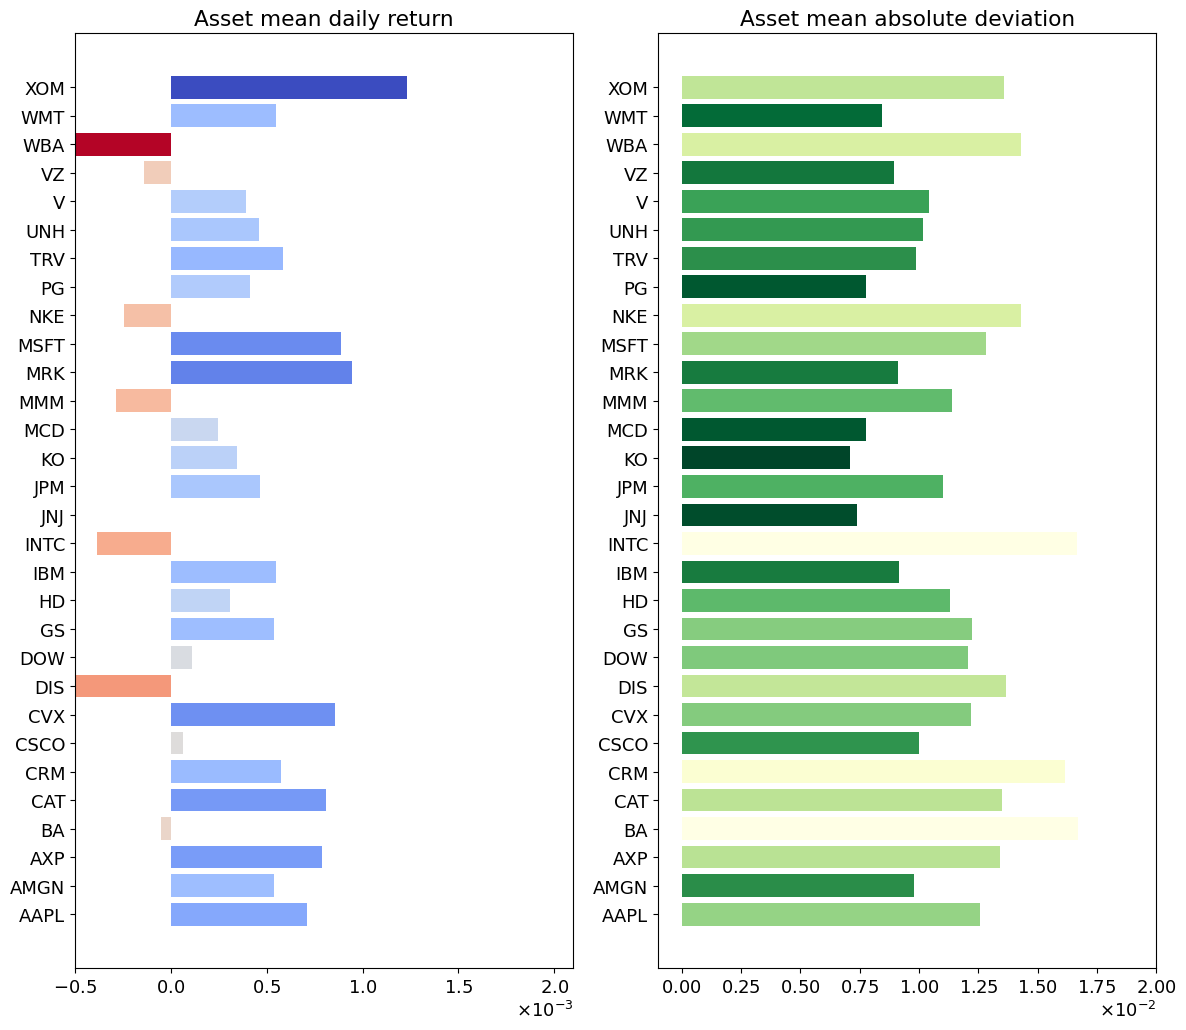

In [ ]:
from matplotlib.ticker import ScalarFormatter


def gradient_barplot(ax, data, color_map):
    min_val = data.min()
    max_val = data.max()
    range_val = max_val - min_val

    for i, val in enumerate(data):
        normalized_val = (val - min_val) / range_val
        color = color_map(normalized_val)
        ax.barh(i, val, color=color)


fig, ax = plt.subplots(1, 2, figsize=(12, 0.35 * len(daily_returns.columns)))

# Choose the color maps
color_map2 = plt.get_cmap("coolwarm").reversed()
color_map3 = plt.get_cmap("YlGn").reversed()

# Asset mean daily return
gradient_barplot(ax[0], mean_return, color_map2)
ax[0].set_title("Asset mean daily return")
ax[0].set_yticks(np.arange(len(mean_return)))
ax[0].set_yticklabels(mean_return.index)
ax[0].set_xlim(-0.0005, 0.0021)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
ax[0].xaxis.set_major_formatter(formatter)

# Asset mean absolute deviation
gradient_barplot(ax[1], mean_absolute_deviation, color_map3)
ax[1].set_title("Asset mean absolute deviation")
ax[1].set_yticks(np.arange(len(mean_absolute_deviation)))
ax[1].set_yticklabels(mean_absolute_deviation.index)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
ax[1].xaxis.set_major_formatter(formatter)
ax[1].set_xlim(-0.001, 0.02)

plt.tight_layout()
plt.show()

We now plot the mean return and mean absolute deviation for all assets using a scatter plot. The scatter plot provides a visual comparison of the trade-off between return and volatility for individual assets.

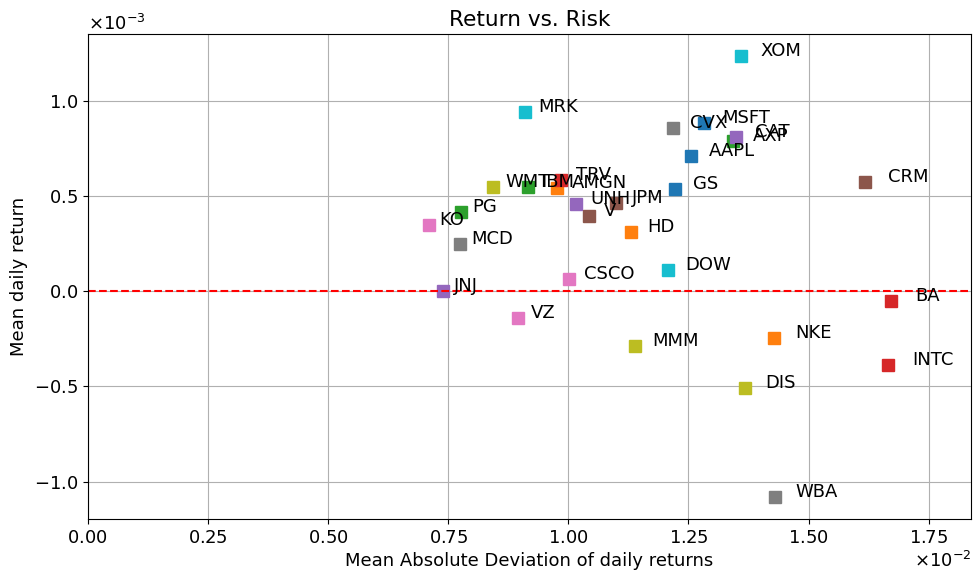

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
    ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

formatterx = ScalarFormatter(useMathText=True)
formatterx.set_scientific(True)
formatterx.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatterx)
formattery = ScalarFormatter(useMathText=True)
formattery.set_scientific(True)
formattery.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formattery)

ax.set_xlim(0, 1.1 * mean_absolute_deviation.max())
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Return vs. Risk")
ax.set_xlabel("Mean Absolute Deviation of daily returns")
ax.set_ylabel("Mean daily return")
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pyomo.environ as pyo


def mad_portfolio(assets):
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    m = pyo.ConcreteModel("MAD portfolio optimization")

    m.R = pyo.Param(mutable=True, default=0)
    m.w_lb = pyo.Param(mutable=True, default=0)
    m.w_ub = pyo.Param(mutable=True, default=1.0)

    m.ASSETS = pyo.Set(initialize=assets.columns)
    m.TIME = pyo.RangeSet(len(daily_returns.index))

    m.w = pyo.Var(m.ASSETS)
    m.u = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    m.v = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.minimize)
    def MAD(m):
        return sum(m.u[t] + m.v[t] for t in m.TIME) / len(m.TIME)

    @m.Constraint(m.TIME)
    def portfolio_returns(m, t):
        date = daily_returns.index[t - 1]
        return m.u[t] - m.v[t] == sum(
            m.w[j] * (daily_returns.loc[date, j] - mean_return[j]) for j in m.ASSETS
        )

    @m.Constraint()
    def sum_of_weights(m):
        return sum(m.w[j] for j in m.ASSETS) == 1

    @m.Constraint()
    def mean_portfolio_return(m):
        return sum(m.w[j] * mean_return[j] for j in m.ASSETS) >= m.R

    @m.Constraint(m.ASSETS)
    def no_short(m, j):
        return m.w[j] >= m.w_lb

    @m.Constraint(m.ASSETS)
    def diversify(m, j):
        return m.w[j] <= m.w_ub

    return m


m = mad_portfolio(assets)

m.w_lb = 0
m.w_ub = 0.2
m.R = 0.001
SOLVER.solve(m)
solver = SolverFactory('highs')
results = solver.solve(m, load_solutions=False)

print(f"Weight lower bound                 {m.w_lb():0.3f}")
print(f"Weight upper bound                 {m.w_ub():0.3f}")
print(
    f"Optimal weights:                   {[round(m.w[j](), 3) if round(m.w[j](), 3) != 0 else 0 for j in m.ASSETS]}"
)
print(f"Fraction of portfolio invested     {m.sum_of_weights():0.3f}")
print(f"Required portfolio daily return    {m.R():0.3f}")
print(f"Portfolio mean daily return        {m.mean_portfolio_return():0.3f}")
print(f"Portfolio mean absolute deviation  {m.MAD():0.5f}")

RuntimeError: A feasible solution was not found, so no solution can be loaded. If using the appsi.solvers.Highs interface, you can set opt.config.load_solution=False. If using the environ.SolverFactory interface, you can set opt.solve(model, load_solutions = False). Then you can check results.termination_condition and results.best_feasible_objective before loading a solution.

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

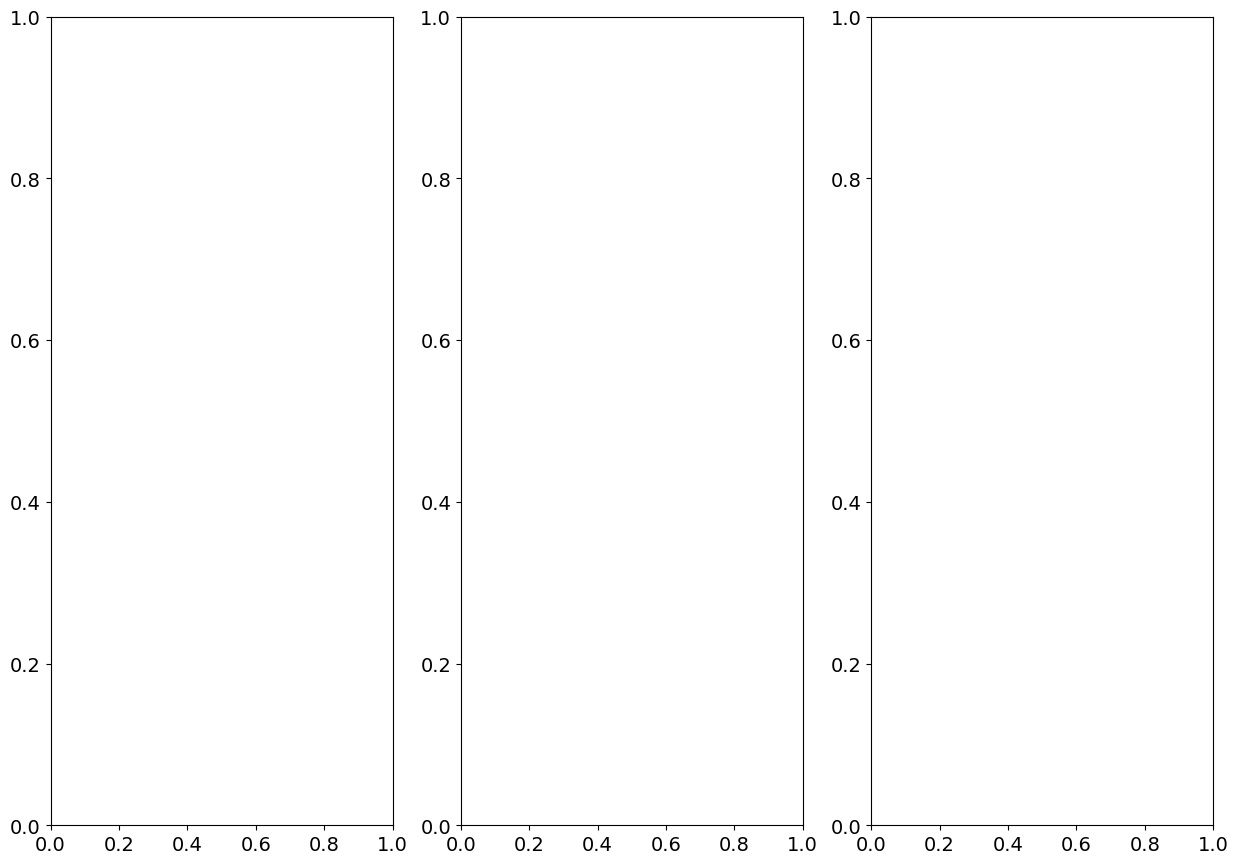

In [ ]:
def mad_visualization(assets, m):
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()
    mad_portfolio_weights = pd.DataFrame(
        [m.w[j]() for j in sorted(m.ASSETS)], index=sorted(m.ASSETS)
    )

    plt.rcParams["font.size"] = 14
    fig, ax = plt.subplots(1, 3, figsize=(15, 0.35 * len(daily_returns.columns)))

    # Choose the color maps
    color_map1 = plt.get_cmap("Greys")
    color_map2 = plt.get_cmap("coolwarm").reversed()
    color_map3 = plt.get_cmap("YlGn").reversed()

    # MAD Portfolio Optimal Weights
    gradient_barplot(ax[0], mad_portfolio_weights[0], color_map1)
    ax[0].set_title("Optimal weights of MAD portfolio")
    ax[0].set_yticks(np.arange(len(mad_portfolio_weights)))
    ax[0].set_yticklabels(mad_portfolio_weights.index)
    ax[0].axvline(m.w_lb(), ls="--", color="g")
    ax[0].axvline(m.w_ub(), ls="--", color="r")
    ax[0].legend(
        ["lower bound", "upper bound"], bbox_to_anchor=(0.97, 0), loc="lower right"
    )
    ax[0].set_xlim(-0.005, 0.21)

    # Asset mean daily return
    gradient_barplot(ax[1], mean_return, color_map2)
    ax[1].set_title("Asset mean daily return")
    ax[1].set_yticks(np.arange(len(mean_return)))
    ax[1].set_yticklabels(mean_return.index)
    ax[1].axvline(m.R(), ls="--", color="g")
    ax[1].axvline(m.mean_portfolio_return() + 0.000015, ls="--", color="r")
    ax[1].legend(
        ["required return", "portfolio return"],
        bbox_to_anchor=(1.01, 0),
        loc="lower right",
    )
    ax[1].set_xlim(-0.0005, 0.0028)

    # Formatter
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax[1].xaxis.set_major_formatter(formatter)

    # Asset mean absolute deviation
    gradient_barplot(ax[2], mean_absolute_deviation, color_map3)
    ax[2].set_title("Asset mean absolute deviation")
    ax[2].set_yticks(np.arange(len(mean_absolute_deviation)))
    ax[2].set_yticklabels(mean_absolute_deviation.index)
    ax[2].axvline(m.MAD(), ls="--", color="r")
    ax[2].legend(["portfolio MAD"], bbox_to_anchor=(1.01, 0), loc="lower right")

    # Formatter
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax[2].xaxis.set_major_formatter(formatter)
    ax[2].set_xlim(-0.001, 0.02)

    plt.tight_layout()
    plt.show()


mad_visualization(assets, m)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
    ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

formatterx = ScalarFormatter(useMathText=True)
formatterx.set_scientific(True)
formatterx.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatterx)
formattery = ScalarFormatter(useMathText=True)
formattery.set_scientific(True)
formattery.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formattery)

ax.set_xlim(0, 1.1 * max(mean_absolute_deviation))
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Return vs. Risk")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

m = mad_portfolio(assets)
for R in np.linspace(0, mean_return.max(), 20):
    m.R = R
    SOLVER.solve(m)
    mad_portfolio_weights = pd.DataFrame(
        [m.w[a]() for a in sorted(m.ASSETS)], index=sorted(m.ASSETS)
    )

    portfolio_returns = daily_returns.dot(mad_portfolio_weights)
    portfolio_mean_return = portfolio_returns.mean()
    portfolio_mean_absolute_deviation = abs(
        portfolio_returns - portfolio_mean_return
    ).mean()
    ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, "ro", ms=10)

plt.tight_layout()
plt.show()

In [16]:
import pyomo.environ as pyo


def mad_portfolio_withriskfreeasset(assets):
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    m = pyo.ConcreteModel()

    m.R = pyo.Param(mutable=True, default=0)
    m.rf = pyo.Param(mutable=True, default=0)
    m.w_lb = pyo.Param(mutable=True, default=0)
    m.w_ub = pyo.Param(mutable=True, default=1.0)

    m.ASSETS = pyo.Set(initialize=assets.columns)
    m.TIME = pyo.RangeSet(len(daily_returns.index))

    m.w = pyo.Var(m.ASSETS)
    m.u = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    m.v = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.minimize)
    def MAD(m):
        return sum(m.u[t] + m.v[t] for t in m.TIME) / len(m.TIME)

    @m.Constraint(m.TIME)
    def portfolio_returns(m, t):
        date = daily_returns.index[t - 1]
        return m.u[t] - m.v[t] == sum(
            m.w[j] * (daily_returns.loc[date, j] - mean_return[j]) for j in m.ASSETS
        )

    @m.Constraint()
    def sum_of_weights(m):
        return sum(m.w[j] for j in m.ASSETS) <= 1

    @m.Constraint()
    def mean_portfolio_return(m):
        return sum(m.w[j] * (mean_return[j] - m.rf) for j in m.ASSETS) >= m.R - m.rf

    @m.Constraint(m.ASSETS)
    def no_short(m, j):
        return m.w[j] >= m.w_lb

    @m.Constraint(m.ASSETS)
    def diversify(m, j):
        return m.w[j] <= m.w_ub

    return m


m = mad_portfolio_withriskfreeasset(assets)
m.w_lb = 0
m.w_ub = 0.2
m.R = 0.001
SOLVER.solve(m)

print(f"Weight lower bound                 {m.w_lb():0.3f}")
print(f"Weight upper bound                 {m.w_ub():0.3f}")
print(
    f"Optimal weights:                   {[round(m.w[j](), 3) if round(m.w[j](), 3) != 0 else 0 for j in m.ASSETS]}"
)
print(f"Fraction of portfolio invested     {m.sum_of_weights():0.3f}")
print(f"Required portfolio daily return    {m.R():0.3f}")
print(f"Portfolio mean daily return        {m.mean_portfolio_return():0.3f}")
print(f"Portfolio mean absolute deviation  {m.MAD():0.5f}")

mad_visualization(assets, m)

RuntimeError: A feasible solution was not found, so no solution can be loaded. If using the appsi.solvers.Highs interface, you can set opt.config.load_solution=False. If using the environ.SolverFactory interface, you can set opt.solve(model, load_solutions = False). Then you can check results.termination_condition and results.best_feasible_objective before loading a solution.

In [ ]:
daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
    ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

formatterx = ScalarFormatter(useMathText=True)
formatterx.set_scientific(True)
formatterx.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatterx)
formattery = ScalarFormatter(useMathText=True)
formattery.set_scientific(True)
formattery.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formattery)

ax.set_xlim(0, 1.1 * max(mean_absolute_deviation))
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Return vs. Risk")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

for color, m in zip(
    ["ro", "go"], [mad_portfolio(assets), mad_portfolio_withriskfreeasset(assets)]
):
    for R in np.linspace(0, mean_return.max(), 20):
        m.R = R
        SOLVER.solve(m)
        mad_portfolio_weights = pd.DataFrame(
            [m.w[a]() for a in sorted(m.ASSETS)], index=sorted(m.ASSETS)
        )
        portfolio_returns = daily_returns.dot(mad_portfolio_weights)
        portfolio_mean_return = portfolio_returns.mean()
        portfolio_mean_absolute_deviation = abs(
            portfolio_returns - portfolio_mean_return
        ).mean()
        ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, color, ms=10)

plt.tight_layout()
plt.show()